In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import uuid

f:\a02_env_ware\ana\Lib\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# 日线数据 - 用于生成交易信号
df_daily = pd.read_csv('BTC_USDT_1day_2021.1.1-2021.12.31一年数据.csv')

# 分钟线数据 - 用于精确判断卖出
df_minute = pd.read_csv('BTC_USDT_30min_2021.1.1-2021.12.31一年数据.csv')

# 给分钟数据添加日期列（用于分组）
df_minute['date'] = pd.to_datetime(df_minute['datatime'], unit='ms').dt.date
df_daily['date'] = pd.to_datetime(df_daily['datatime'], unit='ms').dt.date

In [3]:
df_daily.head()

,Unnamed: 0,datatime,open,high,low,close,volume,date
0,0,1609459200000,28923.63,29600.00,28624.57,29331.69,54182.925011,2021-01-01
1,1,1609545600000,29331.70,33300.00,28946.53,32178.33,129993.873362,2021-01-02
2,2,1609632000000,32176.45,34778.11,31962.99,33000.05,120957.566750,2021-01-03
3,3,1609718400000,33000.05,33600.00,28130.00,31988.71,140899.885690,2021-01-04
4,4,1609804800000,31989.75,34360.00,29900.00,33949.53,116049.997038,2021-01-05


In [4]:
df_minute.head()

,Unnamed: 0,datatime,open,high,low,close,volume,date
0,0,1609459200000,28923.63,29017.50,28690.17,28836.63,1320.688748,2021-01-01
1,1,1609461000000,28836.63,29031.34,28836.62,28995.13,991.122697,2021-01-01
2,2,1609462800000,28995.13,29417.87,28960.35,29385.39,3449.118444,2021-01-01
3,3,1609464600000,29387.07,29470.00,29311.75,29409.99,1953.950027,2021-01-01
4,4,1609466400000,29410.00,29465.26,29201.78,29298.86,1244.624776,2021-01-01


回测

In [82]:
ori_capital = 100000.0 # 初始金额
capital = ori_capital # 当前可用资金

in_ratio = 0.03 # 投资比例 
commission_rate = 0.001  # 手续费率

stop_loss_rate = 0.5 # 止损率
stop_make_rate = 0.5 # 止盈率

all_trades = [] # 用于存储所有交易记录的列表

k1 = 0.5

In [83]:


for i in range(len(df_daily)):

    # 跳过前n个周期
    if i < 1:
        continue

    # 获取数据
    data_today = df_daily.iloc[i] # 今天日线
    data_prev = df_daily.iloc[i-1] # 昨天日线
    today_date = data_today['date'] # 当天日期

    # 判断昨天涨跌
    ''' 
    昨天涨 = True
    昨天跌 = False
    '''
    prev_up = data_prev['close'] > data_prev['open']


    ''' 根据波动率构造交易规则
    (p[t] - p_open[t])/p_open[t] = k1 * pre_range
    pre_range = (p_high[t-1] - p_low[t-1])/p_open[t-1]

    p[t] = k1 * pre_range * p_open[t] + p_open[t]
    p[t] = p_open[t] * (1 + k1 * pre_range)

    
    ''' 
    # 昨天的波动率
    pre_range = (data_prev['high'] - data_prev['low']) / data_prev['open']

    
    if prev_up: # 如果昨天涨 那今天做空
        predict_price = data_today['open'] * (1 - k1 * pre_range)
        if predict_price < data_today['open']: # 可以做空
            direction = -1 # 做空

    else: # 如果昨天跌 那今天做多
        predict_price = data_today['open'] * (1 + k1 * pre_range)
        if predict_price > data_today['open']: # 可以做多
            direction = 1 # 做多

            # 买入
            in_price = data_today['open'] # 买入价格
            in_money = capital * in_ratio # 购买金额
            buy_commission = in_money * commission_rate # 买入手续费
            buy_amount = (in_money - buy_commission)/in_price # 购买数量

            capital = capital - in_money # 余额变化

            in_time = data_today['datatime']
            in_time_readable = datetime.fromtimestamp(in_time/ 1000) # 买入时间

            # 计算止盈止损
            # 做空止盈止损
            if direction == -1:
                stop_loss_price = in_price * (1 + stop_loss_rate)
                stop_make_price = in_price * (1 - stop_make_rate)
            # 做多止盈止损
            elif direction == 1:
                stop_loss_price = in_price * (1 - stop_loss_rate)
                stop_make_price = in_price * (1 + stop_make_rate)
            
            # 扫描分钟数据
            today_minutes = df_minute[df_minute['date'] == today_date].copy()
            out_price = None
            out_time = None

            for idx,minute_data in today_minutes.iterrows():

                 # 止盈：最高价触及止盈价或预测价
                if minute_data['high'] >= min(predict_price,stop_make_price):
                    out_price = min(predict_price,stop_make_price)
                    out_time = minute_data['datatime']
                    break
                
                # 止损：最低价触及止损价
                elif minute_data['low'] <= stop_loss_price:
                    out_price = stop_loss_price
                    out_time = minute_data['datatime']
                    break

            # 日内平仓
            # 未触发则 用当天最后一根k线收盘价平仓
            if out_price is None:
                out_price = today_minutes.iloc[-1]['close']
                out_time = today_minutes.iloc[-1]['datatime']
            out_time_readable = datetime.fromtimestamp(out_time / 1000) # 平仓时间
            
            # 卖出
            sell_money = out_price * buy_amount # 卖出金额
            sell_commission = sell_money * commission_rate # 卖出手续费
            out_money = sell_money - sell_commission # 最终卖出金额

            capital = capital + out_money # 余额变化

            # 计算本次交易信息
            trade = {
                'uuid': str(uuid.uuid4()),  # 交易ID
                'symbol': 'BTC_USDT',  # 交易品种
                
                'in_price': in_price,  # 买入价格
                'out_price': out_price,  # 卖出价格
                
                'stop_loss_price': stop_loss_price,  # 止损价格
                'stop_make_price': stop_make_price,  # 止盈价格
                
                'commission_rate': commission_rate,  # 手续费率
                'commission': 0.0,  # 固定手续费
                
                'profit': out_money-in_money,  # 这笔交易最终盈利
                
                'quantity': buy_amount,  # 交易仓位 交易数量
                
                'in_time': in_time_readable,  # 买入时间
                'out_time': out_time_readable,  # 卖出时间
                
                'direction': direction,  # 交易方向 1=做多 -1=做空
                
            }

            # 记录本次交易信息
            all_trades.append(trade)


# 将交易记录转换为DataFrame
trades_df = pd.DataFrame(all_trades)


In [84]:
trades_df.head()

,uuid,symbol,in_price,out_price,stop_loss_price,stop_make_price,commission_rate,commission,profit,quantity,in_time,out_time,direction
0,c2004044-f752-43e5-a210-2576d8a55368,BTC_USDT,31989.75,33949.530000,15994.875,47984.625,0.001,0.0,177.423852,0.093686,2021-01-05 08:00:00,2021-01-06 07:30:00,1
1,1f26cef0-7a54-45d7-8ba5-50835123c617,BTC_USDT,40088.22,38150.020000,20044.110,60132.330,0.001,0.0,-151.019628,0.074893,2021-01-10 08:00:00,2021-01-11 07:30:00,1
2,9bc97b33-7b18-4566-87ea-309d578ddd80,BTC_USDT,38150.02,35404.470000,19075.010,57225.030,0.001,0.0,-221.525480,0.078579,2021-01-11 08:00:00,2021-01-12 07:30:00,1
3,0bcd753b-4194-4c2d-8b61-8f808aa95541,BTC_USDT,35410.37,34051.240000,17705.185,53115.555,0.001,0.0,-120.677671,0.084471,2021-01-12 08:00:00,2021-01-13 07:30:00,1
4,faefe95f-1410-4da4-82e9-ccc1b1e1aef9,BTC_USDT,34049.15,36018.903035,17024.575,51073.725,0.001,0.0,166.678889,0.087742,2021-01-13 08:00:00,2021-01-14 03:30:00,1


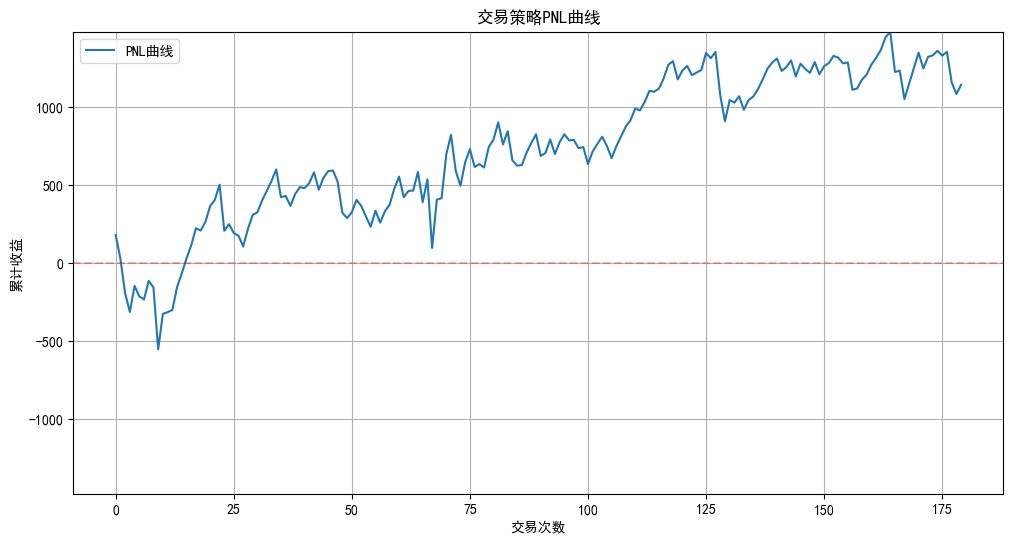

In [85]:
# pnl曲线

import pandas as pd
import matplotlib.pyplot as plt

# 设置中文字体显示
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

# 计算累计收益
pnl = trades_df['profit'].cumsum()

# 获取y轴的最大绝对值，用于设置对称的y轴范围
y_max = max(abs(pnl.max()), abs(pnl.min()))

# 绘制PNL曲线
plt.figure(figsize=(12, 6))
plt.plot(pnl, label='PNL曲线')
plt.axhline(y=0, color='r', linestyle='--', alpha=0.3)  # 添加y=0的参考线
plt.title('交易策略PNL曲线')
plt.xlabel('交易次数')
plt.ylabel('累计收益')
plt.grid(True)
plt.legend()

# 设置y轴范围，使0为中心
plt.ylim(-y_max, y_max)

plt.show()

In [86]:
# ——————交易次数 
trade_count = len(trades_df)
print(f'交易次数：{trade_count}')



# ——————胜率
win_count = len(trades_df[trades_df['profit'] > 0])
win_rate = win_count / trade_count * 100
print(f'胜率：{win_rate:.2f}%')

# ——————交易频率 平均持仓时间

# ——————盈亏比

# 盈利 和 亏损 交易
win_trades = trades_df[trades_df['profit'] > 0]
loss_trades = trades_df[trades_df['profit'] < 0]

# 计算平均值
avg_profit = win_trades['profit'].mean()
avg_loss = abs(loss_trades['profit'].mean())  # 取绝对值，使结果为正数

# 计算盈亏比
risk_reward_ratio = avg_profit / avg_loss
print(f'盈亏比：{risk_reward_ratio:.2f}')

# ——————最大连续亏损次数
is_loss = trades_df['profit'] < 0
current_loss_count = 0
max_loss_count = 0

for i in is_loss:
    if i:
        current_loss_count += 1
    else:
        max_loss_count = max(max_loss_count, current_loss_count)
        current_loss_count = 0
print(f'最大连续亏损次数：{max_loss_count}')


# ——————最大回撤
''' 最低点-最高点/最高点'''
# 计算累计收益
pnl = trades_df['profit'].cumsum()
# 资产净值曲线
capital_curve = pnl + ori_capital
# 计算累计最大值
rolling_max = capital_curve.expanding().max()
# 计算回撤
drawdown = (rolling_max - capital_curve) / rolling_max
# 计算最大回撤
max_drawdown = drawdown.max()

print(f'最大回撤：{max_drawdown:.2%}')  # 使用.2%来格式化为百分比


# ——————夏普比
'''
夏普比率 = 收益 / 收益的标准差
'''
# 计算每笔交易的收益率
returns = trades_df['profit'] / ( trades_df['in_price'] * trades_df['quantity'])

# 计算平均值
mean_return = returns.mean()

# 计算标准差
std_return = returns.std()

# 计算日夏普
sharpe_daily = mean_return / std_return
# 计算年夏普
sharpe_yearly = (mean_return / std_return) * np.sqrt(365)

print(f'夏普比率：{sharpe_yearly:.2f}')

交易次数：180
胜率：65.00%
盈亏比：0.63
最大连续亏损次数：3
最大回撤：0.73%
夏普比率：1.14


In [ ]:
''' 
最好 
胜率 = 50%
盈亏比 = 1.1-1.2 左右

为什么多空策略叠加
1 上涨趋势 下降趋势 都能赚到钱
2 震荡行情 多空策略都小赚

'''